In [1]:
# 导入相关库及配置
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV  # 交叉验证，网格搜索
pd.options.display.max_columns = None  # 取消最大列显示限制
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")# 过滤警告信息，保证清爽输出
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from datetime import datetime
import time
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS

# 导入数据

In [2]:
## 1) 载入训练集和测试集；
train_data= pd.read_csv(r'./data/used_car_train_20200313.csv', sep=' ')
test_data= pd.read_csv(r'./data/used_car_testB_20200421.csv', sep=' ')

In [3]:
train = train_data.drop(['SaleID'], axis=1)
test = test_data.drop(['SaleID'], axis=1)

# 数据预处理

## 数据清洗
1. 空值转换
2. 数据类型转换

In [4]:
# 转换'-'
train['notRepairedDamage'] = train['notRepairedDamage'].replace('-', np.nan) 
test['notRepairedDamage'] = test['notRepairedDamage'].replace('-', np.nan)

# 转换数据类型
train['notRepairedDamage'] = train['notRepairedDamage'].astype('float64')
test['notRepairedDamage'] = test['notRepairedDamage'].astype('float64')

# 检查是否转换成功
train['notRepairedDamage'].unique(), test['notRepairedDamage'].unique()

(array([ 0., nan,  1.]), array([ 0., nan,  1.]))

## 数据倾斜和数据分布

In [5]:
print("查看数据分布：")
for col in pd.Series(train.columns):
    print(train[col].value_counts().sort_values())
    print("\n")  
# 发现power的数据范围存在问题
# seller数据倾斜
# offerType均相同

查看数据分布：
140244      1
122830      1
116685      1
118732      1
131018      1
         ... 
203       233
1541      263
55        280
387       282
708       282
Name: name, Length: 99662, dtype: int64


20151201      1
20130004      1
20151106      1
20151212      1
19911211      1
           ... 
20000002    155
20000010    157
20000004    157
20000011    158
20000008    180
Name: regDate, Length: 3894, dtype: int64


247.0        1
245.0        2
242.0        2
240.0        2
209.0        2
         ...  
29.0      5186
1.0       6038
4.0       8445
19.0      9573
0.0      11762
Name: model, Length: 248, dtype: int64


39        9
38       65
35      180
23      186
33      218
34      227
36      228
18      316
31      318
2       321
37      333
29      406
32      592
28      649
24      772
17      913
30      940
26      966
22     1085
12     1109
20     1236
19     1388
15     1458
21     1547
27     2053
25     2064
8      2077
16     2223
7      2361
3      2461
11     294

### seller和offerType数据倾斜问题

In [6]:
# 发现seller特征在训练集和测试集中偏斜极其严重，对预测没有帮助，删去
train['seller'].value_counts()

0    149999
1         1
Name: seller, dtype: int64

In [7]:
train.drop(['seller'], axis=1, inplace=True)
test.drop(['seller'], axis=1, inplace=True)

In [8]:
# 发现两个数据集的offerType列全为0，删去。
train['offerType'].value_counts()

0    150000
Name: offerType, dtype: int64

In [9]:
train = train.drop(['offerType'], axis=1)
test = test.drop(['offerType'], axis=1)

### power数据范围的问题
power与price之间的相关性系数为0.566101，不能完全忽略

处理策略：
1. 中位数，平均数修改
2. 随机森林填补

In [10]:
# 查看power值大于600的数据分布情况
train[train['power'] > 600]['power'].value_counts().sort_index().head(20)

601    2
602    1
603    2
604    1
610    2
612    4
620    1
625    1
629    1
631    1
650    1
676    1
678    1
680    1
732    1
740    1
751    1
776    1
800    1
801    1
Name: power, dtype: int64

In [11]:
test[test['power'] > 600]['power'].value_counts().sort_index()

603      1
612      1
620      1
629      1
650      1
700      2
703      1
751      1
771      1
999      1
1000     1
1001     1
1002     1
1016     1
1024     1
1055     1
1056     1
1100     1
1103     1
1200     1
1221     1
1230     1
1275     1
1400     1
1405     1
1548     1
1598     1
1600     1
1704     1
1707     1
1800     1
2004     1
2007     1
2009     1
2016     1
2018     1
3750     1
4400     1
6006     1
6010     1
9007     1
9013     1
10522    1
11011    1
11025    1
11509    1
12512    1
15033    1
19208    1
19211    1
Name: power, dtype: int64

In [12]:
# 赛题数据描述讲到，power范围为[0, 600],修正特征power大于600的值
# train有143个值不合法，需要用别的值替换
train[train['power'] > 600]['power'].count()

143

In [13]:
# test有51个不合法需要替换
test[test['power'] > 600]['power'].count()

51

In [14]:
# 使用map函数，以power列的中位数来替换数值超出范围的power
train['power'] = train['power'].map(lambda x: train['power'].mean() if x > 600 else x)
test['power'] = test['power'].map(lambda x: test['power'].mean() if x > 600 else x)

In [15]:
# 检查替换情况
train[train['power'] > 600]['power'].count()

0

In [16]:
test[test['power'] > 600]['power'].count()

0

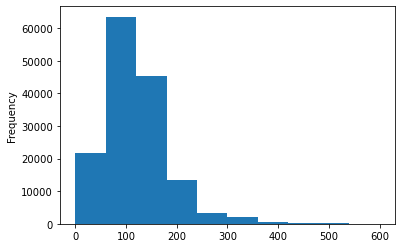

In [17]:
# 检查是否替换成功
train['power'].plot.hist()

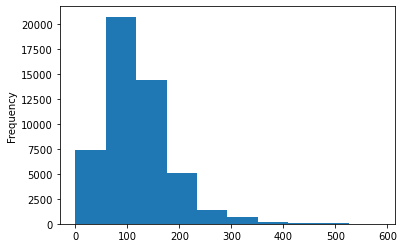

In [18]:
test['power'].plot.hist()

1. 在选择需要删除的特征之前，考虑线性相关系数低的。第一步选中系数绝对值小于0.1的特征， 第二步，抛开线性相关系数，从现实角度思考每个特征对售价的影响
2. 特征v_2, v_6, v_1, v_14, v_13, v_7：由于是连续型变量，理论上具有数学意义。既然跟售价的线性相关系数极低，为降低噪声，避免过拟合，考虑删去；
3. 特征regionCode, brand：并非连续型变量，不具备数学上的可比较性。与售价的线性相关系数低无法说明各自的取值对售价影响不大，保留。
4. 特征name：汽车交易名称，训练集共有99662条不重复值，取值不影响售价，删去。
5. 特征creatDate：（二手）汽车开始售卖时间，范围在 [20150618, 20160407]，间隔短，且与regDate（汽车注册时间）线性相关系数仅为-0.001293，其取值显然对售价影响很小，删去。**(暂时不删，可能购买时间可以组合出新的特征，对汽车价格产生影响)**

## 填补缺失值

In [19]:
# 查看训练集缺失值存在情况
train.isnull().sum()[train.isnull().sum() > 0].sort_values()

model                    1
bodyType              4506
gearbox               5981
fuelType              8680
notRepairedDamage    24324
dtype: int64

In [20]:
# 查看测试集缺失值存在情况
test.isnull().sum()[test.isnull().sum() > 0]

bodyType             1504
fuelType             2924
gearbox              1968
notRepairedDamage    8069
dtype: int64

### 处理model的唯一缺失值
频数最多的进行填补

In [21]:
# 输出缺失所在行
train[train['model'].isnull()]

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
38424,148730,20150809,NaN,37,6.0,1.0,1.0,190.0,2.0,0.0,1425,20160320,47950,41.139365,-2.167089,-3.436008,-7.275037,6.829352,0.181562,0.002092,0.0,0.148487,0.222787,1.6757,-3.25056,0.876001,11.147669,8.658418


In [22]:
# model(车型编码)一般与brand, bodyType, gearbox, power有关，选择以上4个特征与该车相同的车辆的model，选择出现次数最多的值
train[(train['brand'] == 37) & 
      (train['bodyType'] == 6.0) & 
      (train['gearbox'] == 1.0) & 
      (train['power'] == 190)]['model'].value_counts()

157.0    17
199.0    16
202.0     8
200.0     1
Name: model, dtype: int64

In [23]:
# 用157.0填充缺失值
train.loc[38424, 'model'] = 157.0
train.loc[38424]

name                 1.487300e+05
regDate              2.015081e+07
model                1.570000e+02
brand                3.700000e+01
bodyType             6.000000e+00
fuelType             1.000000e+00
gearbox              1.000000e+00
power                1.900000e+02
kilometer            2.000000e+00
notRepairedDamage    0.000000e+00
regionCode           1.425000e+03
creatDate            2.016032e+07
price                4.795000e+04
v_0                  4.113937e+01
v_1                 -2.167089e+00
v_2                 -3.436008e+00
v_3                 -7.275037e+00
v_4                  6.829352e+00
v_5                  1.815618e-01
v_6                  2.091783e-03
v_7                  0.000000e+00
v_8                  1.484868e-01
v_9                  2.227875e-01
v_10                 1.675700e+00
v_11                -3.250560e+00
v_12                 8.760013e-01
v_13                 1.114767e+01
v_14                 8.658418e+00
Name: 38424, dtype: float64

In [24]:
# 查看填充结果
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   regDate            150000 non-null  int64  
 2   model              150000 non-null  float64
 3   brand              150000 non-null  int64  
 4   bodyType           145494 non-null  float64
 5   fuelType           141320 non-null  float64
 6   gearbox            144019 non-null  float64
 7   power              150000 non-null  float64
 8   kilometer          150000 non-null  float64
 9   notRepairedDamage  125676 non-null  float64
 10  regionCode         150000 non-null  int64  
 11  creatDate          150000 non-null  int64  
 12  price              150000 non-null  int64  
 13  v_0                150000 non-null  float64
 14  v_1                150000 non-null  float64
 15  v_2                150000 non-null  float64
 16  v_

In [25]:
# 查看训练集model的填充结果
train.isnull().sum()[train.isnull().sum() > 0]

bodyType              4506
fuelType              8680
gearbox               5981
notRepairedDamage    24324
dtype: int64

### 备份随机森林

In [26]:
train_bck = train.copy(deep = True)
test_bck = test.copy(deep = True)

### 处理bodyType的缺失值
类别中频数最多的进行填补

In [271]:
# 在两个数据集上，车身类型为0.0（豪华轿车）的汽车数量都是最多，所以用0.0来填充缺失值
train.loc[:, 'bodyType'] = train['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)
test.loc[:, 'bodyType'] = test['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)

### 处理fuelType的缺失值
1. 找出与缺失值相关的特征
2. 用相关特征下，缺失特征的众数进行填充

In [92]:
# 猜想：燃油类型与车身类型相关，如豪华轿车更可能是汽油或电动， 而搅拌车大多是柴油
# 创建字典map，保存不同bodyType下， fuelType的众数，并以此填充fuelTyp的缺失值
dict_enu_train, dict_enu_test = {}, {}
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_enu_train[i] = train[train['bodyType'] == i]['fuelType'].mode()[0] # bodyType=i时，fuelType的众数
    dict_enu_test[i] = test[test['bodyType'] == i]['fuelType'].mode()[0]
print(dict_enu_train)
print(dict_enu_test)
# 发现dict_enu_train, dict_enu_test是一样的内容

{0.0: 0.0, 1.0: 0.0, 2.0: 1.0, 3.0: 1.0, 4.0: 0.0, 5.0: 0.0, 6.0: 1.0, 7.0: 1.0}
{0.0: 0.0, 1.0: 0.0, 2.0: 1.0, 3.0: 1.0, 4.0: 0.0, 5.0: 0.0, 6.0: 1.0, 7.0: 1.0}


In [93]:
# 开始填充fuelType缺失值
# 在含fuelType缺失值的条目中，将不同bodyType对应的index输出保存到一个字典中
dict_index_train, dict_index_test = {}, {}

for bodytype in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_index_train[bodytype] = train[(train['bodyType'] == bodytype) & (train['fuelType'].isnull())].index.tolist()
    dict_index_test[bodytype] = test[(test['bodyType'] == bodytype) & (test['fuelType'].isnull())].index.tolist()
    
print(dict_index_train)
print(dict_index_test)

{0.0: [21, 143, 247, 260, 299, 321, 342, 370, 451, 488, 527, 532, 727, 869, 986, 1129, 1132, 1135, 1177, 1243, 1353, 1374, 1434, 1444, 1467, 1637, 1705, 1843, 2008, 2060, 2080, 2330, 2387, 2426, 2591, 2645, 2683, 2836, 3238, 3241, 3384, 3421, 3577, 3729, 3885, 4071, 4345, 4346, 4682, 4685, 4994, 5122, 5178, 5219, 5465, 5525, 5545, 5804, 5960, 6040, 6086, 6111, 6157, 6251, 6274, 6409, 6425, 6426, 6432, 6529, 6667, 6697, 6988, 7134, 7151, 7169, 7175, 7195, 7373, 7414, 7672, 7791, 7846, 8181, 8613, 8626, 8659, 8703, 8731, 8818, 8933, 8953, 9169, 9252, 9345, 9357, 9512, 9523, 9643, 9693, 9744, 9945, 10055, 10227, 10241, 10258, 10315, 10618, 10716, 10828, 10835, 11007, 11044, 11375, 11416, 11496, 11510, 11619, 11914, 11939, 11975, 12020, 12034, 12117, 12224, 12230, 12549, 12811, 12911, 13023, 13107, 13183, 13511, 13534, 13539, 13684, 13952, 14084, 14095, 14209, 14234, 14275, 14459, 14550, 14697, 14807, 14847, 14967, 14983, 14988, 15166, 15349, 15366, 15381, 15417, 15468, 15639, 15756, 15804

In [94]:
# 分别对每个bodyTYpe所对应的index来填充fuelType列
for bt, ft in dict_enu_train.items():
#     train.loc[tuple(dict_index[bt]), :]['fuelType'] = ft  # 注意：链式索引 (chained indexing)很可能导致赋值失败！
    train.loc[dict_index_train[bt], 'fuelType'] = ft  # Pandas推荐使用这种方法来索引/赋值
    test.loc[dict_index_test[bt], 'fuelType'] = ft

### 处理gearbox的缺失值
1. gearbox与price相关性不强
2. gearbox中0占大多数，用0填补

In [280]:
# 训练集，如果缺失，补0
train.loc[:, 'gearbox'] = train['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

# # 对于测试集，为保证预测结果完整性，不能删去任何行。测试集仅有1910个gearbox缺失值，用数量占绝大多数的0.0（手动档）来填充缺失值
test.loc[:, 'gearbox'] = test['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

### 处理notRepairedDamage的缺失值
用数量占比最大的0来填补

In [287]:
# 在整个训练集上有尚未修复损坏的汽车比损坏已修复的汽车售价还要高。
# 为简单化问题，仍使用数量占比最大的0.0来填充所有缺失值
train.loc[:, 'notRepairedDamage'] = train['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)
test.loc[:, 'notRepairedDamage'] = test['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

### 随机森林填补缺失值

In [31]:
# 随机森林填补缺失值
def fill_missing_rf(X, y, to_fill):
    '''
    使用随机森林填补一个特征的缺失值的函数
    参数
    X：要填补的特征矩阵，除标签列之外所有特征组成的矩阵,存在缺失值
    y：完整的，没有缺失值的标签，指的是标签
    to_fill：字符串，要填补的那一列的名称
    '''
    df = X.copy() 
    fill = df.loc[:, to_fill] #取出to_fill那一列
    # 通过concat 得到除了to_fill那一列的所有标签和特征
    df = pd.concat([df.loc[:, df.columns != to_fill], pd.DataFrame(y)], axis = 1) 
    
    # 划分数据集和训练集
    Ytrain = fill[fill.notnull()] #要填补的那一列 非空部分
    Ytest = fill[fill.isnull()] # 要填补的那一列  空的部分
    Xtrain = df.iloc[Ytrain.index, :] #非空部分对应的行
    Xtest = df.iloc[Ytest.index, :] #空的部分对应的列
    
    # 用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100).fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)
    return Ypredict

#### 随机森林填补fuelType

In [ ]:
train_fuelType = train.copy(deep = True)

In [33]:
# 填补bodyType
# 在两个数据集上，车身类型为0.0（豪华轿车）的汽车数量都是最多，所以用0.0来填充缺失值
train_fuelType.loc[:, 'bodyType'] = train_fuelType['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)
test_fuelType.loc[:, 'bodyType'] = test_fuelType['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)

# 填补gearbox
# 训练集，如果缺失，补0
train_fuelType.loc[:, 'gearbox'] = train_fuelType['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)
# # 对于测试集，为保证预测结果完整性，不能删去任何行。测试集仅有1910个gearbox缺失值，用数量占绝大多数的0.0（手动档）来填充缺失值
test_fuelType.loc[:, 'gearbox'] = test_fuelType['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

# 填补notRepairedDamage
# 在整个训练集上有尚未修复损坏的汽车比损坏已修复的汽车售价还要高。
# 为简单化问题，仍使用数量占比最大的0.0来填充所有缺失值
train_fuelType.loc[:, 'notRepairedDamage'] = train_fuelType['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)
test_fuelType.loc[:, 'notRepairedDamage'] = test_fuelType['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

In [36]:
# 划分数据集
temp_x1 = train_fuelType.iloc[:, :12]
temp_x2 = train_fuelType.iloc[:, 13:]
temp_x = pd.concat([temp_x1, temp_x2], axis=1)
temp_y = train_fuelType['price']

In [38]:
# 预测fuelType_pred
fuelType_pred = fill_missing_rf(temp_x, temp_y, 'fuelType')
print(pd.Series(np.round(fuelType_pred)).value_counts())

0.0    6459
1.0    2188
2.0      23
3.0      10
dtype: int64


In [39]:
train_bck.loc[train_bck.loc[:, "fuelType"].isnull(), "fuelType"] = fuelType_pred

In [40]:
# 检查
train_bck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   regDate            150000 non-null  int64  
 2   model              150000 non-null  float64
 3   brand              150000 non-null  int64  
 4   bodyType           145494 non-null  float64
 5   fuelType           150000 non-null  float64
 6   gearbox            144019 non-null  float64
 7   power              150000 non-null  float64
 8   kilometer          150000 non-null  float64
 9   notRepairedDamage  125676 non-null  float64
 10  regionCode         150000 non-null  int64  
 11  creatDate          150000 non-null  int64  
 12  price              150000 non-null  int64  
 13  v_0                150000 non-null  float64
 14  v_1                150000 non-null  float64
 15  v_2                150000 non-null  float64
 16  v_

#### 随机森林填补bodyType

In [41]:
train_bodyType = train_bck.copy(deep = True)

In [42]:
# 填补gearbox
# 训练集，如果缺失，补0
train_bodyType.loc[:, 'gearbox'] = train_bodyType['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

# 填补notRepairedDamage
# 在整个训练集上有尚未修复损坏的汽车比损坏已修复的汽车售价还要高。
# 为简单化问题，仍使用数量占比最大的0.0来填充所有缺失值
train_bodyType.loc[:, 'notRepairedDamage'] = train_bodyType['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

In [43]:
# 划分数据集
temp_x1 = train_bodyType.iloc[:, :12]
temp_x2 = train_bodyType.iloc[:, 13:]
temp_x = pd.concat([temp_x1, temp_x2], axis=1)
temp_y = train_bodyType['price']

In [45]:
# 预测bodyType
bodyType_pred = fill_missing_rf(temp_x, temp_y, 'bodyType')
print(pd.Series(np.round(bodyType_pred)).value_counts())
train_bck.loc[train_bck.loc[:, "bodyType"].isnull(), "bodyType"] = bodyType_pred
print(train_bck.info())

1.0    3653
2.0     745
4.0      59
3.0      46
5.0       3
dtype: int64


#### 随机森林填补gearbox

In [47]:
train_gearbox = train_bck.copy(deep = True)

In [48]:
# 填补notRepairedDamage
train_gearbox.loc[:, 'notRepairedDamage'] = train_gearbox['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

In [49]:
# 划分数据集
temp_x1 = train_gearbox.iloc[:, :12]
temp_x2 = train_gearbox.iloc[:, 13:]
temp_x = pd.concat([temp_x1, temp_x2], axis=1)
temp_y = train_gearbox['price']

In [50]:
# 预测gearbox
gearbox_pred = fill_missing_rf(temp_x, temp_y, 'gearbox')
print(pd.Series(np.round(gearbox_pred)).value_counts())
train_bck.loc[train_bck.loc[:, "gearbox"].isnull(), "gearbox"] = gearbox_pred
print(train_bck.info())

0.0    5226
1.0     755
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   regDate            150000 non-null  int64  
 2   model              150000 non-null  float64
 3   brand              150000 non-null  int64  
 4   bodyType           150000 non-null  float64
 5   fuelType           150000 non-null  float64
 6   gearbox            150000 non-null  float64
 7   power              150000 non-null  float64
 8   kilometer          150000 non-null  float64
 9   notRepairedDamage  125676 non-null  float64
 10  regionCode         150000 non-null  int64  
 11  creatDate          150000 non-null  int64  
 12  price              150000 non-null  int64  
 13  v_0                150000 non-null  float64
 14  v_1                150000 non-null  float64
 15  v_2           

#### 随机森林填补notRepairedDamage

In [51]:
train_notRepairedDamage = train_bck.copy(deep = True)

In [52]:
# 划分数据集
temp_x1 = train_notRepairedDamage.iloc[:, :12]
temp_x2 = train_notRepairedDamage.iloc[:, 13:]
temp_x = pd.concat([temp_x1, temp_x2], axis=1)
temp_y = train_notRepairedDamage['price']

In [53]:
# 预测notRepairedDamage
notRepairedDamage_pred = fill_missing_rf(temp_x, temp_y, 'notRepairedDamage')
print(pd.Series(np.round(notRepairedDamage_pred)).value_counts())
train_bck.loc[train_bck.loc[:, "notRepairedDamage"].isnull(), "notRepairedDamage"] = notRepairedDamage_pred
print(train_bck.info())

0.0    20663
1.0     3661
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   regDate            150000 non-null  int64  
 2   model              150000 non-null  float64
 3   brand              150000 non-null  int64  
 4   bodyType           150000 non-null  float64
 5   fuelType           150000 non-null  float64
 6   gearbox            150000 non-null  float64
 7   power              150000 non-null  float64
 8   kilometer          150000 non-null  float64
 9   notRepairedDamage  150000 non-null  float64
 10  regionCode         150000 non-null  int64  
 11  creatDate          150000 non-null  int64  
 12  price              150000 non-null  int64  
 13  v_0                150000 non-null  float64
 14  v_1                150000 non-null  float64
 15  v_2         

#### test正常填补，无法用随机森林

In [54]:
test.loc[:, 'bodyType'] = test['bodyType'].map(lambda x: 0.0 if pd.isnull(x) else x)

# 开始填充fuelType缺失值
# 在含fuelType缺失值的条目中，将不同bodyType对应的index输出保存到一个字典中
dict_index_test = {}
for bodytype in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_index_test[bodytype] = test[(test['bodyType'] == bodytype) & (test['fuelType'].isnull())].index.tolist()
print(dict_index_test)

test.loc[:, 'gearbox'] = test['gearbox'].map(lambda x: 0.0 if pd.isnull(x) else x)

test.loc[:, 'notRepairedDamage'] = test['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)

{0.0: [4, 77, 135, 146, 150, 174, 175, 184, 322, 376, 411, 452, 457, 458, 518, 523, 560, 618, 632, 663, 718, 719, 796, 845, 869, 942, 993, 997, 1039, 1069, 1126, 1246, 1268, 1294, 1298, 1349, 1352, 1391, 1450, 1466, 1516, 1617, 1624, 1674, 1699, 1716, 1774, 1801, 1809, 1867, 1874, 1882, 1905, 1923, 1930, 1934, 1962, 1967, 1980, 2008, 2018, 2050, 2137, 2148, 2241, 2257, 2273, 2298, 2317, 2358, 2437, 2497, 2531, 2564, 2677, 2744, 2786, 2810, 2830, 2945, 2989, 3060, 3117, 3189, 3256, 3257, 3272, 3275, 3291, 3301, 3313, 3415, 3450, 3463, 3537, 3592, 3596, 3647, 3673, 3754, 3787, 3800, 3834, 3856, 3857, 3903, 3907, 3911, 3912, 3915, 3937, 3965, 4019, 4057, 4126, 4174, 4192, 4234, 4280, 4283, 4293, 4295, 4445, 4448, 4524, 4626, 4633, 4660, 4674, 4723, 4738, 4824, 4839, 4842, 4868, 4917, 4949, 4957, 4962, 4997, 5047, 5084, 5092, 5122, 5155, 5174, 5182, 5234, 5263, 5271, 5272, 5303, 5311, 5447, 5534, 5680, 5709, 5715, 5747, 5829, 5891, 5978, 6099, 6138, 6181, 6320, 6326, 6341, 6417, 6503, 6575

In [56]:
dict_enu_train, dict_enu_test = {}, {}
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    dict_enu_train[i] = train[train['bodyType'] == i]['fuelType'].mode()[0] # bodyType=i时，fuelType的众数
    dict_enu_test[i] = test[test['bodyType'] == i]['fuelType'].mode()[0]
print(dict_enu_train)
print(dict_enu_test)

{0.0: 0.0, 1.0: 0.0, 2.0: 1.0, 3.0: 1.0, 4.0: 0.0, 5.0: 0.0, 6.0: 1.0, 7.0: 1.0}
{0.0: 0.0, 1.0: 0.0, 2.0: 1.0, 3.0: 1.0, 4.0: 0.0, 5.0: 0.0, 6.0: 1.0, 7.0: 1.0}


In [57]:
# 分别对每个bodyTYpe所对应的index来填充fuelType列
for bt, ft in dict_enu_train.items():
    test.loc[dict_index_test[bt], 'fuelType'] = ft

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50000 non-null  int64  
 1   regDate            50000 non-null  int64  
 2   model              50000 non-null  float64
 3   brand              50000 non-null  int64  
 4   bodyType           50000 non-null  float64
 5   fuelType           50000 non-null  float64
 6   gearbox            50000 non-null  float64
 7   power              50000 non-null  float64
 8   kilometer          50000 non-null  float64
 9   notRepairedDamage  50000 non-null  float64
 10  regionCode         50000 non-null  int64  
 11  creatDate          50000 non-null  int64  
 12  v_0                50000 non-null  float64
 13  v_1                50000 non-null  float64
 14  v_2                50000 non-null  float64
 15  v_3                50000 non-null  float64
 16  v_4                500

In [59]:
train = train_bck.copy(deep = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   regDate            150000 non-null  int64  
 2   model              150000 non-null  float64
 3   brand              150000 non-null  int64  
 4   bodyType           150000 non-null  float64
 5   fuelType           150000 non-null  float64
 6   gearbox            150000 non-null  float64
 7   power              150000 non-null  float64
 8   kilometer          150000 non-null  float64
 9   notRepairedDamage  150000 non-null  float64
 10  regionCode         150000 non-null  int64  
 11  creatDate          150000 non-null  int64  
 12  price              150000 non-null  int64  
 13  v_0                150000 non-null  float64
 14  v_1                150000 non-null  float64
 15  v_2                150000 non-null  float64
 16  v_

In [60]:
train.to_csv(r'./data/rf_train_temp.csv',index=False)
test.to_csv(r'./data/rf_test_temp.csv',index=False)

## 日期数据清洗
1. 日期数据不合法：将int => str   str => datetime  当存在非法日期时，string是无法转换到datetime的

In [61]:
print(train[['creatDate','regDate']])
print(test[['creatDate','regDate']])

        creatDate   regDate
0        20160404  20040402
1        20160309  20030301
2        20160402  20040403
3        20160312  19960908
4        20160313  20120103
...           ...       ...
149995   20160327  20000607
149996   20160312  20091102
149997   20160328  20101003
149998   20160401  20060312
149999   20160305  19990204

[150000 rows x 2 columns]
       creatDate   regDate
0       20160308  20000501
1       20160310  19950211
2       20160309  20090606
3       20160314  20020601
4       20160306  20030301
...          ...       ...
49995   20160309  20041005
49996   20160323  20130409
49997   20160316  20041211
49998   20160327  20020702
49999   20160401  20090708

[50000 rows x 2 columns]


In [62]:
# 日期是int类型
print(type(train["creatDate"][0]), type(train["regDate"][0]))
print(type(test["creatDate"][0]), type(test["regDate"][0]))

<class 'numpy.int64'> <class 'numpy.int64'>
<class 'numpy.int64'> <class 'numpy.int64'>


In [63]:
def date_process(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    
    if month < 1:
        month = 7
    date = datetime(year, month, day)
    return date

In [64]:
# apply()是将自定义函数作用到Series或者DataFrame中
train['creatDate'] = train['creatDate'].apply(date_process)
train['regDate'] = train['regDate'].apply(date_process)
test['creatDate'] = test['creatDate'].apply(date_process)
test['regDate'] = test['regDate'].apply(date_process)
print(type(train["creatDate"][0]), type(train["regDate"][0]))
print(type(test["creatDate"][0]), type(test["regDate"][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [65]:
train[['creatDate', 'regDate']]

,creatDate,regDate
0,2016-04-04,2004-04-02
1,2016-03-09,2003-03-01
2,2016-04-02,2004-04-03
3,2016-03-12,1996-09-08
4,2016-03-13,2012-01-03
...,...,...
149995,2016-03-27,2000-06-07
149996,2016-03-12,2009-11-02
149997,2016-03-28,2010-10-03
149998,2016-04-01,2006-03-12


## 分桶

### power分桶
1. power范围是0~600
2. 分桶后，桶内数据不包括左端点，两种方法：1）将power值为0的改成1  2）将第一桶左边界设置为负数(与实际情况不符，实际中power不应该为负数)

In [66]:
# 查看power的范围是0~600
# 考虑划分为20桶
# train边界数据，600共有7条数据，power=0共有12829条
print(train['power'].value_counts().sort_index())
# test power=0共有4390条数据
print(test['power'].value_counts().sort_index())

0.0      12829
1.0          8
2.0          3
3.0          3
4.0          9
         ...  
583.0        1
584.0        1
585.0        3
587.0        1
600.0        7
Name: power, Length: 446, dtype: int64
0.0      4390
1.0         2
2.0         2
4.0         4
5.0        15
         ... 
560.0       4
570.0       1
571.0       1
579.0       3
585.0       2
Name: power, Length: 378, dtype: int64


In [67]:
# data["B"] = data.B.apply(lambda x: 0 if (data['B']>=5) and (data['B']<=8) else 1)
# test.loc[:, 'notRepairedDamage'] = test['notRepairedDamage'].map(lambda x: 0.0 if pd.isnull(x) else x)
# data['B'][(data['B'] >= 5) & (data['B'] <= 8)] = 0
train["power"][(train["power"] == 0)] = 1 # train[train["power"] == 0]['power'] = 1此时无法修改原数据
test["power"][(test["power"] == 0)] = 1 # test[test["power"] == 0]['power'] = 1 此时无法修改原数据
# 检查替换情况
print(train[train["power"] == 0].shape[0])
print(test[test["power"] == 0].shape[0])

0
0


In [68]:
bin = [i*10 for i in range(0, 61, 3)]
print(bin)
print(len(bin)) #桶个数

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600]
21


In [69]:
train['power_bin'] = pd.cut(train["power"], bin, labels=False)
test["power_bin"] = pd.cut(test["power"], bin, labels=False)

In [70]:
#检查分桶情况
print(train['power'])
print(train['power_bin'])
print(test['power'])
print(test['power_bin'])

0          60.0
1           1.0
2         163.0
3         193.0
4          68.0
          ...  
149995    163.0
149996    125.0
149997     90.0
149998    156.0
149999    193.0
Name: power, Length: 150000, dtype: float64
0         1
1         0
2         5
3         6
4         2
         ..
149995    5
149996    4
149997    2
149998    5
149999    6
Name: power_bin, Length: 150000, dtype: int64
0        101.0
1         73.0
2        120.0
3         58.0
4        116.0
         ...  
49995    150.0
49996    179.0
49997    147.0
49998    176.0
49999      1.0
Name: power, Length: 50000, dtype: float64
0        3
1        2
2        3
3        1
4        3
        ..
49995    4
49996    5
49997    4
49998    5
49999    0
Name: power_bin, Length: 50000, dtype: int64


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               150000 non-null  int64         
 1   regDate            150000 non-null  datetime64[ns]
 2   model              150000 non-null  float64       
 3   brand              150000 non-null  int64         
 4   bodyType           150000 non-null  float64       
 5   fuelType           150000 non-null  float64       
 6   gearbox            150000 non-null  float64       
 7   power              150000 non-null  float64       
 8   kilometer          150000 non-null  float64       
 9   notRepairedDamage  150000 non-null  float64       
 10  regionCode         150000 non-null  int64         
 11  creatDate          150000 non-null  datetime64[ns]
 12  price              150000 non-null  int64         
 13  v_0                150000 non-null  float64 

In [72]:
train[train['power_bin'].isnull()]

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,power_bin


# 特征工程

## 特征创造
汽车上线时间：上线出售的时间

汽车注册时间：汽车生产注册的时间

汽车上线时间 < 汽车注册时间

car_age = 汽车上线时间-汽车注册时间

此与price密切相关，时间越久，价钱越低

原数据是int -> str -> datetime

In [73]:
# 汽车上线时间creatDate > 汽车注册时间regDate
train[['creatDate','regDate']]

,creatDate,regDate
0,2016-04-04,2004-04-02
1,2016-03-09,2003-03-01
2,2016-04-02,2004-04-03
3,2016-03-12,1996-09-08
4,2016-03-13,2012-01-03
...,...,...
149995,2016-03-27,2000-06-07
149996,2016-03-12,2009-11-02
149997,2016-03-28,2010-10-03
149998,2016-04-01,2006-03-12


In [74]:
test[['creatDate','regDate']]

,creatDate,regDate
0,2016-03-08,2000-05-01
1,2016-03-10,1995-02-11
2,2016-03-09,2009-06-06
3,2016-03-14,2002-06-01
4,2016-03-06,2003-03-01
...,...,...
49995,2016-03-09,2004-10-05
49996,2016-03-23,2013-04-09
49997,2016-03-16,2004-12-11
49998,2016-03-27,2002-07-02


In [75]:
# 将regDate和creatDate按年月日拆分
# 年
train['regDate_year'] = train['regDate'].dt.year
test['regDate_year'] = test['regDate'].dt.year
train['creatDate_year'] = train['creatDate'].dt.year
test['creatDate_year'] = test['regDate'].dt.year
# 月
train['regDate_month'] = train['regDate'].dt.month
test['regDate_month'] = test['regDate'].dt.month
train['creatDate_month'] = train['creatDate'].dt.month
test['creatDate_month'] = test['regDate'].dt.month
# 日
train['regDate_day'] = train['regDate'].dt.day
test['regDate_day'] = test['regDate'].dt.day
train['creatDate_day'] = train['creatDate'].dt.day
test['creatDate_day'] = test['regDate'].dt.day
# 车龄，单位为天
train['carAge_day'] = (train['creatDate'] - train['regDate']).dt.days
test['carAge_day'] = (test['creatDate'] - test['regDate']).dt.days
# 车龄，单位为年
train['carAge_year'] = (train['creatDate'] - train['regDate']).dt.days / 365
test['carAge_year'] = (test['creatDate'] - test['regDate']).dt.days / 365
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               150000 non-null  int64         
 1   regDate            150000 non-null  datetime64[ns]
 2   model              150000 non-null  float64       
 3   brand              150000 non-null  int64         
 4   bodyType           150000 non-null  float64       
 5   fuelType           150000 non-null  float64       
 6   gearbox            150000 non-null  float64       
 7   power              150000 non-null  float64       
 8   kilometer          150000 non-null  float64       
 9   notRepairedDamage  150000 non-null  float64       
 10  regionCode         150000 non-null  int64         
 11  creatDate          150000 non-null  datetime64[ns]
 12  price              150000 non-null  int64         
 13  v_0                150000 non-null  float64 

In [76]:
# 查看carAge与price之间的相关性
train.corr()['price']['carAge_year']

-0.611402488103291

In [77]:
train.corr()['price']['carAge_day']

-0.6114024881032888

In [78]:
#测试集：增加carAge列
# test['carAge'] = test['creatDate'] - test['regDate']
# test['carAge']

In [79]:
# 测试集：以年为单位，计算carAge
# for i in range(test.shape[0]):
#     test['carAge'][i] = (test['creatDate'][i] - test['regDate'][i]).days / 365
# test['carAge'] = test['carAge'].astype(float)
# print(test['carAge'])
# print(test.info())

# 数据预处理补充：删除无关列

## 删除无关列
1. 在选择需要删除的特征之前，考虑线性相关系数低的。第一步选中系数绝对值小于0.1的特征， 第二步，抛开线性相关系数，从现实角度思考每个特征对售价的影响
2. 特征v_2, v_6, v_1, v_14, v_13, v_7：由于是连续型变量，理论上具有数学意义。既然跟售价的线性相关系数极低，为降低噪声，避免过拟合，考虑删去；
3. 特征regionCode, brand：并非连续型变量，不具备数学上的可比较性。与售价的线性相关系数低无法说明各自的取值对售价影响不大，保留。
4. 特征name：汽车交易名称，训练集共有99662条不重复值，取值不影响售价，删去。
5. 特征creatDate：（二手）汽车开始售卖时间，范围在 [20150618, 20160407]，间隔短，且与regDate（汽车注册时间）线性相关系数仅为-0.001293，其取值显然对售价影响很小，删去。**(暂时不删，可能购买时间可以组合出新的特征，对汽车价格产生影响)**

In [80]:
# 查看各个特征与预测值price之间的相关性系数
train.corr()['price'].sort_index()

bodyType             0.242677
brand               -0.043799
carAge_day          -0.611402
carAge_year         -0.611402
creatDate_day        0.001442
creatDate_month      0.012834
creatDate_year      -0.001702
fuelType             0.203684
gearbox              0.326994
kilometer           -0.440519
model                0.137049
name                 0.002030
notRepairedDamage   -0.224564
power                0.566841
power_bin            0.577206
price                1.000000
regDate_day         -0.002700
regDate_month       -0.001319
regDate_year         0.611814
regionCode           0.014036
v_0                  0.628397
v_1                  0.060914
v_10                -0.246175
v_11                -0.275320
v_12                 0.692823
v_13                -0.013993
v_14                 0.035911
v_2                  0.085322
v_3                 -0.730946
v_4                 -0.147085
v_5                  0.164317
v_6                  0.068970
v_7                 -0.053024
v_8       

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               150000 non-null  int64         
 1   regDate            150000 non-null  datetime64[ns]
 2   model              150000 non-null  float64       
 3   brand              150000 non-null  int64         
 4   bodyType           150000 non-null  float64       
 5   fuelType           150000 non-null  float64       
 6   gearbox            150000 non-null  float64       
 7   power              150000 non-null  float64       
 8   kilometer          150000 non-null  float64       
 9   notRepairedDamage  150000 non-null  float64       
 10  regionCode         150000 non-null  int64         
 11  creatDate          150000 non-null  datetime64[ns]
 12  price              150000 non-null  int64         
 13  v_0                150000 non-null  float64 

In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               50000 non-null  int64         
 1   regDate            50000 non-null  datetime64[ns]
 2   model              50000 non-null  float64       
 3   brand              50000 non-null  int64         
 4   bodyType           50000 non-null  float64       
 5   fuelType           50000 non-null  float64       
 6   gearbox            50000 non-null  float64       
 7   power              50000 non-null  float64       
 8   kilometer          50000 non-null  float64       
 9   notRepairedDamage  50000 non-null  float64       
 10  regionCode         50000 non-null  int64         
 11  creatDate          50000 non-null  datetime64[ns]
 12  v_0                50000 non-null  float64       
 13  v_1                50000 non-null  float64       
 14  v_2   

In [83]:
train.drop(['v_2', 'v_6', 'v_1', 'v_14', 'v_13', 'v_7', 'name', 'creatDate', 'regDate'], axis=1, inplace=True)
test.drop(['v_2', 'v_6', 'v_1', 'v_14', 'v_13', 'v_7', 'name', 'creatDate', 'regDate'], axis=1, inplace=True)

In [84]:
train.shape, test.shape

((150000, 28), (50000, 27))

In [85]:
# 查看处理后的结果
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   model              150000 non-null  float64
 1   brand              150000 non-null  int64  
 2   bodyType           150000 non-null  float64
 3   fuelType           150000 non-null  float64
 4   gearbox            150000 non-null  float64
 5   power              150000 non-null  float64
 6   kilometer          150000 non-null  float64
 7   notRepairedDamage  150000 non-null  float64
 8   regionCode         150000 non-null  int64  
 9   price              150000 non-null  int64  
 10  v_0                150000 non-null  float64
 11  v_3                150000 non-null  float64
 12  v_4                150000 non-null  float64
 13  v_5                150000 non-null  float64
 14  v_8                150000 non-null  float64
 15  v_9                150000 non-null  float64
 16  v_

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              50000 non-null  float64
 1   brand              50000 non-null  int64  
 2   bodyType           50000 non-null  float64
 3   fuelType           50000 non-null  float64
 4   gearbox            50000 non-null  float64
 5   power              50000 non-null  float64
 6   kilometer          50000 non-null  float64
 7   notRepairedDamage  50000 non-null  float64
 8   regionCode         50000 non-null  int64  
 9   v_0                50000 non-null  float64
 10  v_3                50000 non-null  float64
 11  v_4                50000 non-null  float64
 12  v_5                50000 non-null  float64
 13  v_8                50000 non-null  float64
 14  v_9                50000 non-null  float64
 15  v_10               50000 non-null  float64
 16  v_11               500

## 对预测值进行log变换

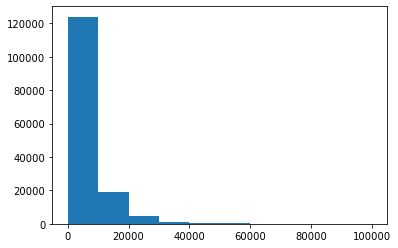

In [87]:
# 查看预测值的具体频数
plt.hist(train['price'], orientation = 'vertical',histtype = 'bar')
plt.show()

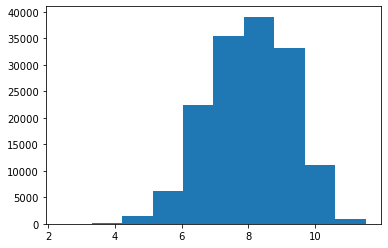

In [88]:
# log变换 z之后的分布较均匀，可以进行log变换进行预测
plt.hist(np.log(train['price']), orientation = 'vertical',histtype = 'bar') 
plt.show()

In [89]:
train['price']

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

In [90]:
#log变换
train['price']=np.log(train['price'])
train['price']

0         7.522941
1         8.188689
2         8.735847
3         7.783224
4         8.556414
            ...   
149995    8.682708
149996    9.159047
149997    8.922658
149998    8.516993
149999    8.455318
Name: price, Length: 150000, dtype: float64

# 数据导出

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   model              150000 non-null  float64
 1   brand              150000 non-null  int64  
 2   bodyType           150000 non-null  float64
 3   fuelType           150000 non-null  float64
 4   gearbox            150000 non-null  float64
 5   power              150000 non-null  float64
 6   kilometer          150000 non-null  float64
 7   notRepairedDamage  150000 non-null  float64
 8   regionCode         150000 non-null  int64  
 9   price              150000 non-null  float64
 10  v_0                150000 non-null  float64
 11  v_3                150000 non-null  float64
 12  v_4                150000 non-null  float64
 13  v_5                150000 non-null  float64
 14  v_8                150000 non-null  float64
 15  v_9                150000 non-null  float64
 16  v_

In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              50000 non-null  float64
 1   brand              50000 non-null  int64  
 2   bodyType           50000 non-null  float64
 3   fuelType           50000 non-null  float64
 4   gearbox            50000 non-null  float64
 5   power              50000 non-null  float64
 6   kilometer          50000 non-null  float64
 7   notRepairedDamage  50000 non-null  float64
 8   regionCode         50000 non-null  int64  
 9   v_0                50000 non-null  float64
 10  v_3                50000 non-null  float64
 11  v_4                50000 non-null  float64
 12  v_5                50000 non-null  float64
 13  v_8                50000 non-null  float64
 14  v_9                50000 non-null  float64
 15  v_10               50000 non-null  float64
 16  v_11               500

In [93]:
train.to_csv(r'./data/rf_train_dropmissing.csv',index=False)
test.to_csv(r'./data/rf_test_dropmissing.csv',index=False)

# 数据建模

In [19]:
train_y=train['price']
train_y

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

In [24]:
train_y.sum()

888499100

In [20]:
del train["price"]
train

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,0,0,20160309,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,0.0,4576,0,0,20160327,45.316543,-3.139095,-1.269707,-0.736609,-1.505820,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,0.0,2826,0,0,20160312,45.972058,-3.143764,-0.023523,-2.366699,0.698012,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,0.0,3302,0,0,20160328,44.733481,-3.105721,0.595454,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,0.0,1877,0,0,20160401,45.658634,-3.204785,-0.441680,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


In [21]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train,train_y,test_size=0.3)

## 随机森林
回归树

In [22]:
begin=time.time()
## Train and Predict
print('Predict RF...')
model_rf = RandomForestRegressor(n_estimators=100,n_jobs=-1)
model_rf = model_rf.fit(x_train,y_train)
val_rf = model_rf.predict(x_val)
MAE_Weighted = mean_absolute_error(np.exp(y_val),np.exp(val_rf))
print('MAE_Weighted:',MAE_Weighted)
end=time.time()
print("运行时间：",end-begin)
subA_rf = np.exp(model_rf.predict(test))

Predict RF...


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# 学习曲线
begin=time.time()
axisx =np.arange(230,270,10)
rs = []
for i in axisx:
    model_rf = RandomForestRegressor(n_estimators =i,n_jobs=-1)
    model_rf = model_rf.fit(x_train,y_train)
    val_rf = model_rf.predict(x_val)
    MAE_Weighted = mean_absolute_error(np.exp(y_val),np.exp(val_rf))
    rs.append(MAE_Weighted)    
print(axisx[rs.index(min(rs))],min(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="RandomForestRegressor")
plt.ylabel("MAE")
plt.xlabel("n_estimators")
plt.legend()
plt.show()
end=time.time()
print("运行时间：",end-begin)

In [ ]:
sub= pd.read_csv(r'./data/used_car_sample_submit.csv', sep=',')
sub

In [ ]:
subA_rf = pd.Series(subA_rf)
subA_rf

In [ ]:
sub['price'] = subA_rf
sub

In [ ]:
sub.to_csv(r'./data/carAge_sub_rf.csv',index=False)

## xgboost

In [512]:
import time
begin=time.time()
## Train and Predict
print('Predict XGB...')
model_xgb = XGBRegressor(base_score=0.5, booster='gbtree',learning_rate=0.13999999999999996, n_estimators=250,
       n_jobs=1, objective='reg:linear',random_state=1, reg_alpha=0, reg_lambda=1, subsample=0.7999999999999999) 
model_xgb = model_xgb.fit(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_Weighted = mean_absolute_error(np.exp(y_val),np.exp(val_xgb))
print('MAE_Weighted:',MAE_Weighted)
end=time.time()
print("运行时间：",end-begin)
subA_xgb =np.exp(model_xgb.predict(test))

Predict XGB...
[19:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
R^2： 0.9616648178038166
MAE_Weighted: 634.6768002606498
运行时间： 84.34966564178467


In [ ]:
sub['price'] = pd.Series(subA_xgb)
sub.to_csv(r'./data/carAge_sub_xgb.csv',index=False)

## lightGBM

In [332]:
import time
begin=time.time()
print('Predict LightGBM...')
model_lgb = lgb.LGBMRegressor(n_estimators =14000,learning_rate=0.04,num_leaves=60,subsample= 0.85)
model_lgb = model_lgb.fit(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_Weighted = mean_absolute_error(np.exp(y_val),np.exp(val_lgb))
end=time.time()
print("运行时间：",end-begin)
subA_lgb = np.exp(model_lgb.predict(test))
print('MAE_Weighted:',MAE_Weighted)

Predict LightGBM...
运行时间： 292.6877167224884
MAE_Weighted: 522.3170987460828


In [333]:
sub['price'] = pd.Series(subA_lgb)
sub.to_csv(r'./data/carAge_sub_lightGBM.csv',index=False)

## stacking融合